In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
import Differential_Equation_Solver as DES
import numba as nb

## Physical Constants

* ``alpha``: The unitless fine structure constant, $\alpha = 1/137$ 
* ``dtda_part2``:  Used in driver functions but can be calculated out here, $\frac{2\pi}{3} $ 
* ``f_pi``: Pion decay constant, $f_{\pi} = 131 \text{ MeV}$
* ``Gf``: Fermi constant, $G_F = 1.166 \times 10 ^{-11} \text{ MeV}^{-2}$
* ``me``: Electron mass, $m_e = 0.511 \text{ MeV}$
* ``mpi_neutral``: Neutral pion mass, $m_{\pi^0} = 135 \text{ MeV}$
* ``mpi_charged``: Charged pion mass, $m_{\pi^{\pm}} = 139.569 \text{ MeV}$
* ``mPL``: Planck mass, $m_{\rm Pl} = 1.124 \times 10^{22} \text{ MeV}$
* ``mu``: Muon mass, $m_{\mu} = 105.661 \text{ MeV}$
* ``eps_e``: Constant used in several integrations, $\epsilon_e = \frac{m_e}{m_{\mu}}$
* ``Enumax``: Maximum energy of the muon and electron neutrino from the decay of the muon in the rest frame of the muon, $E_{\nu \rm max} = \frac{m_{\mu}}{2}(1-\epsilon_e^2)$

In [2]:
alpha = 1/137         
dtda_part2 = 2*np.pi/3     
f_pi = 131              
Gf = 1.166*10**-11      
me = .511               
mpi_neutral = 135       
mpi_charged = 139.569   
mPL = 1.124*10**22      
mu = 105.661  
eps_e = me/mu
Enumax = (mu/2)*(1-(eps_e)**2)

## Model-specific parameters

* ``n``: Number of steps for Gauss-Laguerre and Gauss-Legendre quadrature, max is about 150 before it stops working well
* ``num``: Total number of ODEs that will be solved, that is, total number of $N_E$ ODEs (one for each energy bin) plus two for temperature and time
* ``steps``: Number of steps over independent variable (``a``) that will be saved and returned by DES
* ``d_steps``: Number of steps between main steps over independent variable that will not be returned by DES in an effort to save computational expense but not lose accuracy
* ``a_init``: Initial scale factor 
* ``a_final``: Final scale factor, DES will stop when this value is reached OR when the number of steps is reached, whichever happens first 
* ``y_init``: Initial array of y values, that is, dependent variables. Initial values of $N_E$ are all left as 0 here, initial values for temperature and time are set on the next line.
* ``y_init[-2]``: Initial temperature in MeV, for the duration of the code ``y[-2]`` is temperature
* ``y_init[-1]``: Initial time in units of MeV$^{-1}$, for the duration of the code ``y[-1]`` is time. ($1$ s $= \hbar \times 1.52 \times 10^{21}$ MeV$^{-1}$)
* ``boxsize``: Space accounted for by each energy bin
* ``e_array``: Energy array, each bin accounts for all neutrinos with energies between $E$ and $E +$ ``boxsize``
* Gauss-Laguerre quadrature: A mathematical tool to evaluate any integral from $[0,\infty)$ using Laguerre polynomials. You send $n$ to the function and it returns the $n$ roots of the $n^{\rm th}$ Laguerre polynomial. These $n$ roots are ``x_values``. Each root has a corresponding weight in ``w_values``. By evaluating $\sum_{i=1}^n w_i * e^{-x_i}f(x_i)$, an approximation for $\int_0^{\infty} f(x) dx$ is returned.
* ``x_values``: The $n$ roots of the $n^{\rm th}$ Laguerre polynomial
* ``w_values``: The weights that correspond to ``x_values``
* Gauss-Legendre quadrature: A mathematical tool to evaluate any integral from $[-1,1]$ using Legendre polynomials. You send $n$ to the function and it returns the $n$ roots of the $n^{\rm th}$ Legendre polynomial. These n roots are ``x_valuese``. Each root has a corresponding weight in ``w_valuese``. By evaluating $\sum_{i=1}^n w_i f(x_i)$, an approximation for $\int_{-1}^1 f(x) dx$ is returned. Note that this can be molded to calculate any definite integral, $\int_a^b f(x) dx$.
* ``x_valuese``: The $n$ roots of the $n^{\rm th}$ Legendre polynomial
* ``w_valuese``: The weights that correspond to ``x_valuese``
* ``D``: Parameter that describes the dilution of the sterile neutrinos from the time they decoupled, we change this later
* ``fT``: Fraction of mass converted to thermal energy in the plasma, we really change this later

In [3]:
n = 10                       
num = 82                      
steps = 120                   
d_steps = 1                   
a_init = 1/50                 
a_final = 2                   
y_init = np.zeros(num) 
y_init[-2] = 50               
y_init[-1] = 0                
boxsize = 2
e_array = np.linspace(0,int(num-2)*boxsize,int(num-2))     
x_values, w_values = np.polynomial.laguerre.laggauss(10) 
x_valuese, w_valuese = np.polynomial.legendre.leggauss(10)

D = 1            
fT = .5          

## Integral-related functions

### ``I1``  - the integrand in $\rho_{e^{\pm}}$
The energy density of electrons and positrons, $\rho_{e^{\pm}}$, is $$ \rho_{e^{\pm}} = \frac{2T^4}{\pi^2}\int_0^\infty \text{I1 }d\xi = \frac{2T^4}{\pi^2}\int_0^\infty\frac{\xi^2\sqrt{\xi^2+x^2}}{e^{\sqrt{\xi^2+x^2}}+1}d\xi. $$ This function, however, only computes the *integrand* portion of that equation. In addition, what is returned by this function has an additional $e^{\xi}$ as necessitated by the mathematical tool we use to evaluate this integral, Gauss-Laguerre quadrature (see above). The coefficient, $\left(2T^4 \right)/ \pi^2$, is ultimately embedded into $dT/da$ below.
* **Inputs**: 
    * ``xi``: A dimensionless expression of $\xi = p/T$, and our dummy variable of integration. Notice that $\rho_{e^{\pm}}$ is entirely a function of temperature (in thermal equilibrium) as momentum is integrated out.
    * ``x``: The adjusted temperature, $x = m_e/T$, at the time step at which $\rho_{e^{\pm}}$ is being calculated.
* **Outputs**: 
    * ``E_den``: The integrand at the given $\xi$ and $x$ value: $$ \frac{e^{\xi} \xi^2\sqrt{\xi^2+x^2}}{e^{\sqrt{\xi^2+x^2}}+1} $$
    
### ``I2`` - the integrand in $P_{e^{\pm}}$
The pressure of electrons and positrons, $P_{e^{\pm}}$, is $$ P_{e^{\pm}} = \frac{2T^4}{3\pi^2}\int_0^\infty \text{I2 } d\xi = \frac{2T^4}{3\pi^2}\int_0^\infty\frac{e^{\xi} \xi^4}{\sqrt{\xi^2+x^2} \left(e^{\sqrt{\xi^2+x^2}}+1 \right)} d\xi. $$ This function, however, only computes the *integrand* portion of that equation. In addition, what is returned by this function has an additional $e^{\xi}$ as necessitated by the mathematical tool we use to evaluate this integral, Gauss-Laguerre quadrature (see above). The coefficient, $\left(2T^4 \right)/ \left(3\pi^2 \right)$, is ultimately embedded into $dT/da$ below.
* **Inputs**: 
    * ``xi``: A dimensionless expression of $\xi = p/T$, and our dummy variable of integration. Notice that $P_{e^{\pm}}$ is entirely a function of temperature (in thermal equilibrium) as momentum is integrated out.
    * ``x``: The adjusted temperature, $x = m_e/T$, at the time step at which $P_{e^{\pm}}$ is being calculated.
* **Outputs**: 
    * ``Pressure``: The integrand at the given $\xi$ and $x$ value: $$ \frac{e^{\xi} \xi^4 }{\sqrt{\xi^2+x^2} \left(e^{\sqrt{\xi^2+x^2}}+1 \right)} $$
    
### ``dI1`` - the integrand in $d\rho_{e^{\pm}}/dT$
The derivative of the energy density of electrons and positrons, $d\rho_{e^{\pm}}/dT$, is $$ \frac{d\rho_{e^{\pm}}}{dT} = \frac{8T^3}{\pi^2}\int_0^\infty \text{I1 }d\xi + \frac{2Tm_e^2}{\pi^2} \int_0^{\infty} \text{dI1 } d\xi = \frac{8T^3}{\pi^2}\int_0^\infty\frac{\xi^2\sqrt{\xi^2+x^2}}{e^{\sqrt{\xi^2+x^2}}+1}d\xi + \frac{2Tm_e^2}{\pi^2} \int_0^{\infty} \frac{\sqrt{\xi^2 + x^2}}{e^{\sqrt{\xi^2 + x^2}}+1} d\xi . $$ 

Notice that we already have code for the integrand in the first term, ``I1``!! This function computes the *integrand* portion of the second term, ``dI1``. In addition, what is returned by this function has an additional $e^{\xi}$ as necessitated by the mathematical tool we use to evaluate this integral, Gauss-Laguerre quadrature (see above). The coefficients of both terms, $\left( 8T^3 \right) / \pi^2$ and $ \left( 2Tm_e^2 \right)/ \pi^2$ are both ultimately embedded into $dT/da$ below.
* **Inputs**: 
    * ``xi``: A dimensionless expression of $\xi = p/T$, and our dummy variable of integration. Notice that $d\rho_{e^{\pm}}$ is entirely a function of temperature (in thermal equilibrium) as momentum is integrated out.
    * ``x``: The adjusted temperature, $x = m_e/T$, at the time step at which $d\rho_{e^{\pm}}$ is being calculated.
* **Outputs**: 
    * ``dE_den``: The integrand at the given $\xi$ and $x$ value: $$\frac{e^{\xi} \sqrt{\xi^2 + x^2}}{e^{\sqrt{\xi^2 + x^2}}+1}$$
    
### ``dI2`` - the integrand in $dP_{e^{\pm}}/dT$
The derivative of the energy density of electrons and positrons, $d\rho_{e^{\pm}}/dT$, is $$ \frac{d\rho_{e^{\pm}}}{dT} = \frac{8T^3}{3\pi^2} \int_0^\infty \text{I2 }d\xi + \frac{2Tm_e^2}{3\pi^2} \int_0^{\infty} \text{dI2 } d\xi = \frac{8T^3}{3\pi^2} \int_0^\infty \frac{\xi^4}{\sqrt{\xi^2+x^2} \left(e^{\sqrt{\xi^2+x^2}}+1 \right)} d\xi + \frac{2Tm_e^2}{3\pi^2} \int_0^{\infty} \frac{3\xi^2}{\sqrt{\xi^2 + x^2} \left(e^{\sqrt{\xi^2 + x^2}}+1 \right)} d\xi . $$ 

Notice that we already have code for the integrand in the first term, ``I2``!! This function computes the *integrand* portion of the second term, ``dI2``. In addition, what is returned by this function has an additional $e^{\xi}$ as necessitated by the mathematical tool we use to evaluate this integral, Gauss-Laguerre quadrature (see above). The coefficients of both terms, $\left( 8T^3 \right)/\left(3\pi^2 \right)$ and $ \left(2Tm_e^2 \right)/\left(3\pi^2 \right)$ are both ultimately embedded into $dT/da$ below.
* **Inputs**: 
    * ``xi``: A dimensionless expression of $\xi = p/T$, and our dummy variable of integration. Notice that $dP_{e^{\pm}}$ is entirely a function of temperature (in thermal equilibrium) as momentum is integrated out.
    * ``x``: The adjusted temperature, $x = m_e/T$, at the time step at which $dP_{e^{\pm}}$ is being calculated.
* **Outputs**: 
    * ``dPressure``: The integrand at the given $\xi$ and $x$ value: $$ \frac{e^{\xi} 3\xi^2}{\sqrt{\xi^2 + x^2} \left(e^{\sqrt{\xi^2 + x^2}}+1 \right)} $$
    
### ``calculate_integral`` 
Uses a Gauss-Laguerre quadrature to integrate over one of the four integrands above, ``I1``, ``I2``, ``dI1``, or ``dI2``. Note that ``x_values``, as defined above, is the array of roots of the $n^{\rm th}$ Laguerre polynomial, while ``x`` is the adjusted temperature that is specific to each individual calculation. I couldn't really think of a more appropriate way to name either of them, but it is really only in this one particular instance that it's confusing.
* **Inputs**: 
    * ``I``: The function that returns the integrand over which we will be performing the integral. 
    * ``x``: The adjusted temperature, $x = m_e/T$, at the time step at which the integral, ``I``, is being calculated.
* **Outputs**: 
    * ``integral``: A summation over the integrand ``I`` using Gauss-Laguerre quadrature.
    
### ``trapezoid``
Performs a summation over a given array using trapezoid rule. Good for relatively simple integrals over smooth curves.
* **Inputs**: 
    * ``array``: Array of values that we will be integrating over, i.e., an array of some variable that depends on ``x``
    * ``dx``: Spaces between bins of a linearly spaced independent variable array
* **Outputs**: 
    * ``total``: The result of the summation: $$ \sum_{i=0}^{len(\text{array})-1} \frac{ dx * (\text{array}[i]+\text{array}[i+1])}{2} $$

In [4]:
def I1(xi,x): 
    numerator = (np.e**xi)*(xi**2)*((xi**2+x**2)**.5)
    denominator = np.e**((xi**2+x**2)**.5)+1
    E_den = numerator/denominator
    return E_den

def I2(xi,x):
    numerator = (np.e**xi)*(xi**4)
    denominator = ((xi**2+x**2)**.5)*(np.e**((xi**2+x**2)**.5)+1)
    Pressure = numerator/denominator
    return Pressure

def dI1(xi,x): 
    numerator = (np.e**xi)*((xi**2+x**2)**.5)
    denominator = np.e**((xi**2+x**2)**.5)+1
    dE_den = numerator/denominator
    return dE_den

def dI2(xi,x):
    numerator = (np.e**xi)*3*(xi**2)
    denominator = ((xi**2+x**2)**.5)*(np.e**((xi**2+x**2)**.5)+1)
    dPressure = numerator/denominator
    return dPressure

def calculate_integral(I,x): 
    integral = np.sum(w_values*I(x_values,x)) 
    return integral

def trapezoid(array,dx): #dx will just be boxsize for our cases currently
    total = np.sum(dx*(array[1:]+array[:-1])/2)
    return total

## Decay rates

### ``rate1``
* **Inputs**: 
    * ``ms``: Mass of the sterile neutrino 
    * ``angle``: Mixing angle of the sterile neutrino with the three active flavors
* **Outputs**: 
    * ``Gamma``: The decay rate of decay 1, $$\Gamma_1 = \frac{9 G_F^2 \alpha m_s^5 \sin^2(\theta)}{512 \pi^4}$$

### ``rate2``
* **Inputs**: 
    * ``ms``: Mass of the sterile neutrino 
    * ``angle``: Mixing angle of the sterile neutrino with the three active flavors
* **Outputs**: 
    * ``Gamma``: The decay rate of decay 2, $$\Gamma_2 = \frac{G_F^2 f_{\pi}^2}{16 \pi} m_s (m_s^2-m_{\pi^0}^2) \sin^2(\theta)$$
    
### ``rate3``
* **Inputs**: 
    * ``ms``: Mass of the sterile neutrino 
    * ``angle``: Mixing angle of the sterile neutrino with the three active flavors
* **Outputs**: 
    * ``Gamma``: The decay rate of decay 3, there is an extra 2 coefficient out front because $\nu_s$ can decay into either $\pi^+$ and $e^-$ OR $\pi^-$ and $e^+$, $$\Gamma_3 = 2 \frac{G_F^2 f_{\pi}^2}{16 \pi} m_s \sqrt{(m_s^2 - (m_{\pi^0}+m_e)^2)*(m_s^2 - (m_{\pi^0}-m_e)^2)} \sin^2(\theta)$$ 

### ``rate4``
* **Inputs**: 
    * ``ms``: Mass of the sterile neutrino 
    * ``angle``: Mixing angle of the sterile neutrino with the three active flavors
* **Outputs**: 
    * ``Gamma``: The decay rate of decay 4, there is an extra 2 coefficient out front because $\nu_s$ can decay into either $\pi^+$ and $\mu^-$ OR $\pi^-$ and $\mu^+$, $$\Gamma_4 = 2 \frac{G_F^2 f_{\pi}^2}{16 \pi} m_s \sqrt{(m_s^2 - (m_{\pi^{\pm}}+m_{\mu})^2)*(m_s^2 - (m_{\pi^{\pm}}-m_{\mu})^2)} \sin^2(\theta)$$ 
    
### ``ts``
* **Inputs**: 
    * ``ms``: Mass of the sterile neutrino 
    * ``angle``: Mixing angle of the sterile neutrino with the three active flavors
* **Outputs**: 
    * ``tau``: The overall lifetime of the sterile neutrino at the given mass and mixing angle, $$\tau_s = \frac{1}{\Gamma_1 + \Gamma_2 + \Gamma_3 + \Gamma_4}$$

In [5]:
def rate1(ms,angle): 
    numerator = 9*(Gf**2)*alpha*(ms**5)*((np.sin(angle))**2)
    denominator = 512*np.pi**4
    Gamma = numerator/denominator
    return Gamma

def rate2(ms,angle):
    part1 = (Gf**2)*(f_pi**2)/(16*np.pi)
    part2 = ms*((ms**2)-(mpi_neutral**2))*(np.sin(angle))**2
    Gamma = part1*part2
    return Gamma

def rate3(ms,angle):
    part1 = (Gf**2)*(f_pi**2)/(16*np.pi)
    parentheses = ((ms**2) - (mpi_charged+me)**2)*((ms**2) - (mpi_charged-me)**2)
    part2 = ms * ((parentheses)**(1/2)) * (np.sin(angle))**2
    Gamma = part1*part2
    return 2*Gamma 

def rate4(ms,angle):
    part1 = (Gf**2)*(f_pi**2)/(16*np.pi)
    parentheses = ((ms**2) - (mpi_charged+mu)**2)*((ms**2) - (mpi_charged-mu)**2)
    part2 = ms * ((parentheses)**(1/2)) * (np.sin(angle))**2
    Gamma = part1*part2
    return 2*Gamma 

def ts(ms,angle):
    tau = 1/(rate1(ms,angle)+rate2(ms,angle)+rate3(ms,angle)+rate4(ms,angle))
    return tau

## Relativity functions

### ``diracdelta`` 
In the decay of type $\nu_s \to B+C$, this function describes the monoenergtic probability distribution of the energy of particle $B$ in the rest frame of $\nu_s$
* **Inputs**: 
    * ``E``: Energy of current energy bin that we're looking at, always sends ``i*boxsize``
    * ``E_I``: Energy of particle $B$ in the rest frame of the parent particle
    * ``de``: Boxsize of current energy array
* **Outputs**: 
    * ``output``: If $E$ is within half a boxsize of $E_I$, then $E$ is in the energy bin that recieves all of the monoenergetic decay products of energy $E_I$, output = $\delta(E-E_{B})$
        
### ``diracdelta2``  
In the decay of type $\nu_s \to A \to B + C$, this function describes the energy distribution in the Home Frame ($\nu_s$ rest frame) of a particle that is monoenergetic in the Other Frame (particle $A$'s rest frame) (describes energy distribution of particles $B$ or $C$ in this scenario in the rest frame of $\nu_s$)
* **Inputs**: 
    * ``E``: Energy of current energy bin that we're looking at, always sends ``i*boxsize``
    * ``EBmin``: Maximum energy of particle $B$ in the Home Frame
    * ``EBmax``: Minimum energy of particle $B$ in the Home Frame
    * ``E_B``: Energy of particle $B$ in the Other Frame, i.e, energy of particle $B$ in the rest frame of particle $A$ from the monoenergetic decay of $A \to B+C$
    * ``v``: The speed of particle $A$'s rest frame relative to the sterile neutrino rest frame, $v = p_A/E_A$
    * ``gamma``: The Lorentz factor of particle $A$'s rest frame relative to the sterile neutrino rest frame, $\gamma = E_A/m_A $
* **Outputs**: 
    * ``tophat``: The probability of making a particle with energy $E$ in the rest frame of the sterile neutrino, $\dfrac{1}{2\gamma v E_B} \cases{1 \text{ if } E_{\rm min}<E<E_{\rm max} \\ 0 \text{ otherwise}}$
    
### ``EB`` 
In the decay of type $A \to B+C$ (where $B$ is monoenergetic), returns the energy of $B$ in the rest frame of $A$.
* **Inputs**: 
    * ``mA``: Mass of particle $A$ (decaying particle)
    * ``mB``: Mass of particle $B$ (decay product whose energy we're interested in)
    * ``mC``: Mass of particle $C$ (other decay product)
* **Outputs**: 
    * ``E_B``: Energy of particle $B$ in the rest frame of particle $A$, $$E_B = \frac{m_A^2 + m_B^2 - m_C^2}{2m_A}$$
    
### ``Gammamua``
Integral over differential decay rate of the muon in decay types III and IV in the rest frame of the muon. Lorentz transformed further in other parts of code to return to rest frame of the sterile neutrino, but this part of the code exclusively works with the three-product decay of the muon in the rest frame of the muon. The primes are there to remind us that this needs to be further transformed to be in the Home Frame.

So the purpose of this code is to take an neutrino energy bin in the rest frame of the mother particle of the muon, $E$, figure out the minimum and maximum neutrino energies ($a$ and $b$, respectively) that could Lorentz transform to $E$ from the rest frame of the muon. 
* **Inputs**: 
    * ``a``: Given that the current neutrino energy bin is $E$, the minimum possible neutrino energy in the rest frame of the muon that could Lorentz transform to $E$ in the rest frame of the mother particle of the muon is $a = \frac{E}{\gamma_{\mu}(1+v_{\mu})}$. 
    * ``b``: Given that the current neutrino energy bin is $E$, the maximum possible neutrino energy in the rest frame of the muon that could Lorentz transform to $E$ in the rest frame of the mother particle of the muon is $ \frac{E}{\gamma_{\mu}(1-v_{\mu})}$. However, the neutrinos from this decay process cannot have a energy greater than ``Enumax`` where $E_{\nu \rm max} = \frac{m_{\mu}}{2}(1-\epsilon_e^2)$, so we set $b = {\rm min}(E_{\rm max}', \frac{E}{\gamma_{\mu}(1-v_{\mu})})$.
* **Outputs**: 
    * ``Gam_mua``: The integral over the differential decay rate $\frac{d\Gamma_{\mu}'}{dE_{\nu}'}\frac{dE_{\nu}'}{E_{\nu}'}$ in the rest frame of the muon, from the smallest possible energy of the neutrino that could Lorentz transform to $E$ in the mother particle rest frame, $a$, to the greatest possible energy of the neutrino that could Lorentz transform to $E$ in the mother particle rest frame, $b$, $$ \begin{aligned} \Gamma_{\mu_a}' &= \int^{b}_a \frac{d\Gamma_{\mu}'}{dE_{\nu}'} \frac{dE_{\nu}'}{E_{\nu}'} \\ &= \frac{8 G_F m_{\mu}^2}{16\pi^3} \int^b_a \frac{E_{\nu}'}{1-\frac{2E_{\nu}'}{m_{\mu}}} \left( 1 - \frac{2E_{\nu}'}{m_{\mu}} - \frac{m_e^2}{m_{\mu}^2} \right)^2 dE_{\nu}'  \\ &= \frac{-8 G_F m_{\mu}^2}{16\pi^3} \left. \left( \frac{\frac{1}{4} m_e^4 m_{\mu} \log{\left(|{2 E_{\nu}' - m_{\mu}}|\right)} + \frac{1}{6} E_{\nu}' \left(3 m_e^4 + 6E_{\nu}' m_e^2 m_{\mu} + m_{\mu}^2 E_{\nu}' (4E_{\nu}' - 3m_{\mu}) \right)}{m_{\mu}^3} \right) \right\vert_a^b \end{aligned} $$


### ``Gammamub``
Calculates integral over differential decay rate of the muon in decay types III and IV in the rest frame of the muon, but without the $E_{\nu}'$ in the denominator to isolate just the muon decay rate part of the integral. Lorentz transformed further in other parts of code to return to rest frame of the sterile neutrino, but this part of the code exclusively works with the three-product decay of the muon in the rest frame of the muon. The primes are there to remind us that this needs to be further transformed to be in the Home Frame.   
* **Inputs**: 
    * None
* **Outputs**: 
    * ``Gam_mub``: The integral over the differential decay rate $\frac{d\Gamma_{\mu}'}{dE_{\nu}'}dE_{\nu}'$ from the smallest possible energy of the neutrino in the muon rest frame, 0, to the greatest possible energy of the neutrino in the muon rest frame, $E_{\rm max}'$, $$ \begin{aligned} \Gamma_{\mu_b}' &= \int^{E_{\rm max}'}_0 \frac{d\Gamma_{\mu}'}{dE_{\nu}'}dE_{\nu}' \\ &= \frac{8 G_F m_{\mu}^2}{16\pi^3} \int^{E_{\rm max}'}_0 \frac{(E_{\nu}')^2}{1-\frac{2E_{\nu}'}{m_{\mu}}} \left( 1 - \frac{2E_{\nu}'}{m_{\mu}} - \frac{m_e^2}{m_{\mu}^2} \right)^2 dE_{\nu}'  \\ &= \frac{-8 G_F m_{\mu}^2}{16\pi^3} \left. \left(\frac{3 m_e^4 m_{\mu}^2 \log{\left(|{2 E_{\nu}' - m_{\mu}}|\right)} + 6 m_e^4 E_{\nu}' (m_{\mu}+E_{\nu}') + 16 m_e^2 m_{\mu} {E_{\nu}'}^3 + 4 m_{\mu}^2 {E_{\nu}'}^3 (3{E_{\nu}'} - 2m_{\mu})}{24 m_{\mu}^3} \right) \right\vert_0^{E_{\rm max}'} \end{aligned}$$
    
### ``Gam_mub``
Integral over $\frac{d\Gamma_{\mu}'}{dE_{\nu}'}dE_{\nu}'$, it's constant and only needs to be calculated once

### ``u_integral``
Using Gauss-Legendre quadrature, this function calculates the integral over all possible muon energies in the rest frame of the pion (for Decay Type IV) to Lorentz transform the active neutrino spectra into this rest frame.
* **Inputs**: 
    * ``E_mumin``: Minimum energy of the muon from the pion decay in the rest frame of the sterile neutrino
    * ``E_mumax``: Maximum energy of the muon from the pion decay in the rest frame of the sterile neutrino
    * ``Eactive``: Current neutrino energy bin in the Home Frame, ``i*boxsize``, $E$
    * ``ms``: Mass of the sterile neutrino 
    * ``angle``: Mixing angle of the sterile neutrino with the three active flavors
* **Calculations** 
    * ``Eu_array``: Array of muon energies in the rest frame of the sterile neutrino that is created in accordance with Gauss-Legendre quadrature
    * ``gammau``: The Lorentz factor of the pion's rest frame to the rest frame of the sterile neutrino at the current energy bin
    * ``pu``: The momentum of the muon in the sterile neutrino rest frame at the current energy bin
    * ``vu``: The speed of the pion's rest frame relative to the sterile neutrino's rest frame at the current energy bin
    * ``Gam_mua``: The integral over the muon differential decay rate, $\Gamma_{\mu_a}' = \int_a^b \frac{d\Gamma_{\mu}'}{dE_{\nu}'}\frac{dE_{\nu}'}{E_{\nu}'}$ where $a= E/(\gamma_{\mu}(1+v_{\mu}))$ and $b= {\rm min}(E_{\nu \rm max}, E/(\gamma_{\mu}(1-v_{\mu})))$.
* **Outputs**: 
    * ``integral``: Calculates the integral $$\int_{E_{\mu \rm min}}^{E_{\mu \rm max}} \frac{\Gamma_{\mu_a}'}{2\gamma_{\mu}v_{\mu}} dE_{\mu}$$

In [6]:
def diracdelta(E,E_I,de): 
    difference = E-E_I
    if -(1/2)*de<= difference <(1/2)*de: 
        output = 1/de
    else:
        output = 0
    return output
    
def diracdelta2(E,EBmin,EBmax,E_B,gamma,v):  # hmm, doesn't send boxsize
    if (EBmin-boxsize)<=E<=EBmin: #if energy is in the first box
        tophat = (E+boxsize-EBmin)/(2*gamma*v*E_B*boxsize)
    elif (EBmax-boxsize)<=E<=EBmax: #if energy is in the last box
        tophat = (EBmax-E)/(2*gamma*v*E_B*boxsize)
    elif EBmin<= E <=EBmax:  #if energy is in any of the middle boxes 
        tophat = 1/(2*gamma*v*E_B) 
    else:
        tophat = 0
    return tophat

def EB(mA,mB,mC): 
    E_B = (mA**2 + mB**2 - mC**2)/(2*mA)
    return E_B

def Gammamua(a,b): #for both electron neutrinos and muon neutrinos for decay types III and IV
    if a>Enumax:
        return 0
    constant = 8*Gf*(mu**2)/(16*np.pi**3)
    part_b1 = (-1/4)*(me**4)*mu*np.log(abs(2*b-mu))
    part_b2 = (-1/6)*b
    part_b3 = 3*(me**4)+6*(me**2)*mu*b
    part_b4 = (mu**2)*b*(4*b-3*mu)
    part_b = (part_b1+part_b2*(part_b3+part_b4))/mu**3
    part_a1 = (-1/4)*(me**4)*mu*np.log(abs(2*a-mu))
    part_a2 = (-1/6)*a
    part_a3 = 3*(me**4)+6*(me**2)*mu*a
    part_a4 = (mu**2)*a*(4*a-3*mu)
    part_a = (part_a1+part_a2*(part_a3+part_a4))/mu**3
    integral = part_b-part_a
    Gam_mua = constant*integral
    return Gam_mua

def Gammamub(): #for both electron neutrinos and muon neutrinos for decay types III and IV 
    constant = 8*Gf*(mu**2)/(16*np.pi**3)
    part_a1 = 3*(me**4)*(mu**2)*np.log(abs(2*Enumax-mu))
    part_a2 = 6*(me**4)*Enumax*(mu+Enumax)
    part_a3 = 16*(me**2)*mu*(Enumax**3)
    part_a4 = 4*(mu**2)*(Enumax**3)*(3*Enumax - 2*mu)
    part_a5 = 24*mu**3
    part_b1 = 3*(me**4)*(mu**2)*np.log(abs(-mu))/part_a5
    integral = ((part_a1+part_a2+part_a3+part_a4)/part_a5)-part_b1
    Gam_mub = -1*constant*integral
    return Gam_mub

Gam_mub = Gammamub()

def u_integral(E_mumin,E_mumax,Eactive,ms,angle):
    Eu_array = ((E_mumax-E_mumin)/2)*x_valuese + ((E_mumax+E_mumin)/2)
    integral = 0
    for i in range(n):
        gammau = Eu_array[i]/mu
        pu = (Eu_array[i]**2-mu**2)**(1/2)
        vu = pu/Eu_array[i]
        Gam_mua = Gammamua(Eactive/(gammau*(1+vu)),min(Enumax,Eactive/(gammau*(1-vu))))
        integral = integral + (w_valuese[i]*((E_mumax-E_mumin)/2)*(1/(2*gammau*vu))*Gam_mua)
    return integral

# ODES 

The following functions are all seperate driver functions for decays 1, 2, 3, and 4. In other codes I think it will really be better to have them all smushed into one driver function, but this worked best here since the goal was to create a graph that dealt with each decay process individually. Here I will describe calculations for $dt/da$ and $dT/da$ since these occur in every driver function (which is obviously inefficient in the long run). Then, the description of each driver function will simply describe the parts of the driver unique to that decay process.

### ``dt/da``, some of this is outdated and will need editing in newer versions of the code

$$ \frac{dt}{da} = \frac{m_{\rm Pl}}{2 a} \frac{1}{\sqrt{\cfrac{2\pi}{3} \left( \cfrac{T^4 \pi^2}{15} + \cfrac{2T^4 \text{``I1``}}{\pi^2} + \cfrac{7 \pi^2 T_{\rm cm}^4}{40} + m_sn_s +  {\displaystyle \int } \cfrac{df}{da} \cfrac{1}{E^2 a^3} \right)}} $$


### ``dT/da``, first term in the numerator changes to $\frac{1}{T} \frac{dQ}{da}$ in later code

 $$\frac{dT}{da} = \cfrac{ \cfrac{f_T m_s a^3}{\tau_s T} n_s \cfrac{dt}{da} -3a^2T^3 \left[ \cfrac{4\pi^2}{45} + \cfrac{2}{\pi^2} \left( \text{``I1``} + \cfrac{1}{3} \text{``I2``} \right) \right]}{3T^2a^3 \left[ \cfrac{4\pi^2}{45} + \cfrac{2}{\pi^2} \left( \text{``I1``} + \cfrac{1}{3} \text{``I2``} \right) \right] - \cfrac{2 m_e^2 a^3}{\pi^2} \left( \text{``dI1``} + \cfrac{1}{3} \text{``dI2``} \right)} $$ 

## Decay 1

### ``driver1``
Decay 1: $$\nu_s \rightarrow \nu + \gamma$$
Home Frame is simply the rest frame of the sterile neutrino, no Other Frame is considered.
* **Inputs**: 
    * ``ms``: Mass of the sterile neutrino 
    * ``angle``: Mixing angle of the sterile neutrino with the three active flavors
    * ``ns``: Function that defines $n_s$, the number density of sterile neutrinos:
         * ### ``ns``
             * **Inputs**:
                 * ``Tcm``: Comoving temperature ($1/a$)
                 * ``t``: The time in units of MeV$^{-1}$
                 * ``ms``: Mass of the sterile neutrino 
                 * ``angle``: Mixing angle of the sterile neutrino with the three active flavors
             * **Outputs**:
                 * ``n_s``: The number density of the sterile neutrino at the given time and comoving temperature (since $T_{\rm cm}$ describes the sterile neutrino population), $$ n_s = \frac{3D \zeta(3)}{2 \pi^2} T_{\rm cm}^3 e^{-t/\tau_s}$$
* **Calculations**:
    * ``E_B1``: The energy of the active neutrino decay product in the Home Frame, $E_{\nu1} = \frac{m_s}{2}$ 
    * ``dPdtdE1``: The probability that a sterile neutrino produces an active neutrino with energy between $E$ and $E+dE$ via decay 1 in time interval $dt$, $$\left(\frac{dP}{dt \, dE}\right)_1 = \Gamma_1 \delta(E-E_{\nu1}) $$
* **Outputs**: 
    * ``a_array1``: An array of $a$ values (scale factor) as the code progressed. Steps between $a$ in the array are variable due to the variable step size algorithm in ``DES``, and the array stops either when ``a_final`` is reached or when ``len(a_array1)`` reaches ``steps``, whichever happens first. This should be identical to ``a_array2``, ``a_array3``, and ``a_array4``.
    * ``y_matrix1``: A matrix of the solutions to all the differential equations that correspond to the scale factor in ``a_array1``. That is, ``y_matrix1[i]`` is an array of the solutions to all the differential equations at ``a_array1[i]``. Specifically, ``y_matrix1[i][-2]`` is the temperature at ``a_array1[i]``, ``y_matrix1[i][-1]`` is the time at ``a_array1[i]``, and the rest of the values in ``y_matrix1[i]`` are the total number of neutrinos $N_E$ with energies between $E$ and $E+dE$ FROM DECAY 1 for all the energy bins at ``a_array1[i]`` (Later these dependent variables will be $f(\epsilon)$ instead of $N_E$). $$\frac{dN_E}{da} = \left(\frac{dP}{dt \, dE}\right)_1 n_s a^3 \frac{dt}{da}. $$ 

### ``derivatives1``
* **Inputs**: 
    * ``a``: Scale factor from previous time step 
    * ``y``: All dependent variables ($N_E$, temperature, and time) from previous time step
* **Outputs**: 
    * ``d_array1``: Derivatives at this previous time step that will be used to calculate ``a`` and ``y`` for the next time step

In [7]:
def driver1(ms,mixangle,ns):

    E_B1 = ms/2 
    
    def derivatives1(a,y): 
        d_array1 = np.zeros(len(y))
        Tcm = y_init[-2]*a_init/a
        
        dtda_part1 = mPL/(2*a)
        dtda_part3 = (y[-2]**4*np.pi**2)/15
        dtda_part4 = 2*y[-2]**4*calculate_integral(I1,me/y[-2])/np.pi**2
        dtda_part5 = (7*(np.pi**2)*(Tcm**4))/40
        dtda_part6 = ms*ns(Tcm,y[-1],ms,mixangle)
        dtda_part7 = trapezoid(y[1:int(num-2)]/(e_array[1:int(num-2)]**2*a**3),boxsize) #index 1 is starting point to avoid dividing by 0
        dtda = dtda_part1/(dtda_part2*(dtda_part3+dtda_part4+dtda_part5+dtda_part6+dtda_part7))**.5
        d_array1[-1] = dtda
        
        dTda_constant1 = (4*np.pi**2/45)+(2/np.pi**2)*(calculate_integral(I1,me/y[-2]) + (1/3)*(calculate_integral(I2,me/y[-2])))
        dTda_constant2 = 2*me**2*a**3/(np.pi**2)
        dTda_numerator1 = -3*a**2*y[-2]**3*dTda_constant1
        dTda_numerator2 = ((fT*ms*a**3)/(ts(ms,mixangle)*y[-2]))*ns(Tcm,y[-1],ms,mixangle)*dtda
        dTda_denominator = (3*y[-2]**2*a**3*dTda_constant1) + dTda_constant2*(calculate_integral(dI1,me/y[-2]) + (1/3)*(calculate_integral(dI2,me/y[-2])))
        dTda = (dTda_numerator1 + dTda_numerator2)/dTda_denominator
        d_array1[-2] = dTda
    
        for i in range (1,num-2):
            dPdtdE1 = rate1(ms,mixangle)*diracdelta((i*boxsize),E_B1,boxsize)
            d_array1[i] = dPdtdE1*ns(Tcm,y[-1],ms,mixangle)*a**3*dtda
            
        return d_array1
    a_array1, y_matrix1 = DES.destination_x(derivatives1, y_init, steps, d_steps, a_init, a_final)
    return a_array1,y_matrix1

## Decay 2

### ``driver2``
Decay 2: $$\nu_s \rightarrow \nu + \pi^0$$ Home Frame is simply the rest frame of the sterile neutrino, no Other Frame is considered.
* **Inputs**: 
    * ``ms``: Mass of the sterile neutrino 
    * ``angle``: Mixing angle of the sterile neutrino with the three active flavors
    * ``ns``: Function that defines $n_s$, the number density of sterile neutrinos:
         * ### ``ns``
             * **Inputs**:
                 * ``Tcm``: Comoving temperature ($1/a$)
                 * ``t``: The time in units of MeV$^{-1}$
                 * ``ms``: Mass of the sterile neutrino 
                 * ``angle``: Mixing angle of the sterile neutrino with the three active flavors
             * **Outputs**:
                 * ``n_s``: The number density of the sterile neutrino at the given time and comoving temperature (since $T_{\rm cm}$ describes the sterile neutrino population), $$ n_s = \frac{3D \zeta(3)}{2 \pi^2} T_{\rm cm}^3 e^{-t/\tau_s}$$
* **Calculations**:
    * ``E_B2``: The energy of the active neutrino decay product in the Home Frame, $E_{\nu2} = \frac{m_s^2 - m_{\pi^0}}{2m_s}$
    * ``dPdEdt2``: The probability that a sterile neutrino produces an active neutrino with energy between $E$ and $E+dE$ via decay 2 in time interval $dt$, $$\left(\frac{dP}{dt \, dE}\right)_2 = \Gamma_2 \delta(E-E_{\nu2}) .$$ 
* **Outputs**: 
    * ``a_array2``: An array of $a$ values (scale factor) as the code progressed. Steps between $a$ in the array are variable due to the variable step size algorithm in ``DES``, and the array stops either when ``a_final`` is reached or when ``len(a_array2)`` reaches ``steps``, whichever happens first. This should be identical to ``a_array1``, ``a_array3``, and ``a_array4``.
    * ``y_matrix2``: A matrix of the solutions to all the differential equations that correspond to the scale factor in ``a_array2``. That is, ``y_matrix2[i]`` is an array of the solutions to all the differential equations at ``a_array2[i]``. Specifically, ``y_matrix2[i][-2]`` is the temperature at ``a_array2[i]``, ``y_matrix2[i][-1]`` is the time at ``a_array2[i]``, and the rest of the values in ``y_matrix2[i]`` are the total number of neutrinos $N_E$ with energies between $E$ and $E+dE$ FROM DECAY 2 for all the energy bins at ``a_array2[i]`` (Later these dependent variables will be $f(\epsilon)$ instead of $N_E$). $$\frac{dN_E}{da} = \left(\frac{dP}{dt \, dE}\right)_2 n_s a^3 \frac{dt}{da}. $$

### ``derivatives2``
* **Inputs**: 
    * ``a``: Scale factor from previous time step 
    * ``y``: All dependent variables ($N_E$, temperature, and time) from previous time step
* **Outputs**: 
    * ``d_array2``: Derivatives at this previous time step that will be used to calculate ``a`` and ``y`` for the next time step 

In [8]:
def driver2(ms,mixangle,ns):
    
    E_B2 = (ms**2 - mpi_neutral**2)/(2*ms)
    
    def derivatives2(a,y):
        d_array2 = np.zeros(len(y))
        Tcm = y_init[-2]*a_init/a
        
        dtda_part1 = mPL/(2*a)
        dtda_part3 = (y[-2]**4*np.pi**2)/15
        dtda_part4 = 2*y[-2]**4*calculate_integral(I1,me/y[-2])/np.pi**2
        dtda_part5 = (7*(np.pi**2)*(Tcm**4))/40
        dtda_part6 = ms*ns(Tcm,y[-1],ms,mixangle)
        dtda_part7 = trapezoid(y[1:int(num-2)]/(e_array[1:int(num-2)]**2*a**3),boxsize) #1 is included to avoid dividing by 0
        dtda = dtda_part1/(dtda_part2*(dtda_part3+dtda_part4+dtda_part5+dtda_part6+dtda_part7))**.5
        d_array2[-1] = dtda
        
        dTda_constant1 = (4*np.pi**2/45)+(2/np.pi**2)*(calculate_integral(I1,me/y[-2]) + (1/3)*(calculate_integral(I2,me/y[-2])))
        dTda_constant2 = 2*me**2*a**3/(np.pi**2)
        dTda_numerator1 = -3*a**2*y[-2]**3*dTda_constant1
        dTda_numerator2 = ((fT*ms*a**3)/(ts(ms,mixangle)*y[-2]))*ns(Tcm,y[-1],ms,mixangle)*dtda
        dTda_denominator = (3*y[-2]**2*a**3*dTda_constant1) + dTda_constant2*(calculate_integral(I1,me/y[-2]) + (1/3)*(calculate_integral(dI2,me/y[-2])))
        dTda = (dTda_numerator1 + dTda_numerator2)/dTda_denominator
        d_array2[-2] = dTda
    
        for i in range (1,num-2):
            dPdtdE2 = rate2(ms,mixangle)*diracdelta((i*boxsize),E_B2,boxsize)
            d_array2[i] = dPdtdE2*ns(Tcm,y[-1],ms,mixangle)*a**3*dtda
              
        return d_array2
    a_array2, y_matrix2 = DES.destination_x(derivatives2, y_init, steps, d_steps, a_init, a_final)
    return a_array2,y_matrix2

## Decay 3

### ``driver3``
Decay 3a: $$\nu_s \rightarrow \pi^{\pm} + e^{\mp} \rightarrow \nu_{\mu} + \mu^{\pm} $$ Home Frame is the rest frame of the sterile neutrino, Other Frame is the rest frame of the pion. We're interested in the muon neutrino produced by the decay of the pion.

Decay 3b: $$\nu_s \rightarrow \pi^{\pm} + e^{\mp} \rightarrow \nu_{\mu} + \mu^{\pm} \rightarrow e^{\pm} + \nu_{\mu} + \nu_{e}$$ Home Frame is the rest frame of the sterile neutrino, Other Frame is the rest frame of the pion, Other Other Frame is rest frame of the muon. We're interested in the muon neutrino and electron neutrino produced by the decay of the muon, which have the same spectra.
* **Inputs**: 
    * ``ms``: Mass of the sterile neutrino 
    * ``angle``: Mixing angle of the sterile neutrino with the three active flavors
    * ``ns``: Function that defines $n_s$, the number density of sterile neutrinos:
         * ### ``ns``
             * **Inputs**:
                 * ``Tcm``: Comoving temperature ($1/a$)
                 * ``t``: The time in units of MeV$^{-1}$
                 * ``ms``: Mass of the sterile neutrino 
                 * ``angle``: Mixing angle of the sterile neutrino with the three active flavors
             * **Outputs**:
                 * ``n_s``: The number density of the sterile neutrino at the given time and comoving temperature (since $T_{\rm cm}$ describes the sterile neutrino population), $$ n_s = \frac{3D \zeta(3)}{2 \pi^2} T_{\rm cm}^3 e^{-t/\tau_s}$$
* **Calculations referring to initial part of decay 3**:
    * ``E_pi3``: Energy of the charged pion from decay 3 in the Home Frame, $E_{\pi^{\pm}_3} = \frac{m_s^2 + m_{\pi^{\pm}}^2 - m_e^2}{2m_s}$
    * ``p_pi3``: Momentum of the charged pion from decay 3 in the Home Frame, $p_{\pi^{\pm}_3} = \sqrt{E_{\pi^{\pm}_3}^2 - m_{\pi^{\pm}}^2}$
    * ``v3``: The speed of the pion rest frame relative to the sterile neutrino rest frame, $v_3 = p_{\pi^{\pm}_3}/E_{\pi^{\pm}_3}$
    * ``gammapi3``: The Lorentz factor of the pion's rest frame relative to the sterile neutrino rest frame, $\gamma_{\pi3} = E_{\pi^{\pm}_3}/m_{\pi^{\pm}} $
* **Calculations referring to decay 3a**:
    * ``E_B3``: Energy of the muon neutrino from the decay of the pion in the Other Frame (rest frame of the pion), $E_{B3} = \frac{m_{\pi^{\pm}}^2-m_{\mu}^2}{2m_{\pi^{\pm}}}$
    * ``E_B3max``: Maximum energy of the muon neutrino in the Home Frame, $E_{B3_{\rm max}} = \gamma_{\pi3} E_{B3}(1 + v_3)$
    * ``E_B3min``: Minimum energy of the muon neutrino in the Home Frame, $E_{B3_{\rm min}} = \gamma_{\pi3} E_{B3}(1 - v_3)$
    * ``dPdtdE3a``: The probability that a sterile neutrino produces an active neutrino with energy between $E$ and $E+dE$ via decay 3a in time interval $dt$. **Note!**: this does not include the antineutrino produced by this process the other half of the time, multiply by two to include the antineutrino: $$\left(\frac{dP}{dt \, dE}\right)_{3a} = \frac{\Gamma_3}{2}  \dfrac{1}{2\gamma_{\pi3} v_3 E_{B3}} \cases{1 \text{ if } E_{B3_{\rm min}}<E<E_{B3_{\rm max}} \\ 0 \text{ otherwise}} $$
* **Calculations referring to decay 3b**:    
    * ``E_mu3``: The energy of the muon from the decay of the pion in the Other Frame (rest frame of the pion), $E_{\mu_3} = m_{\pi^{\pm}} - E_{B3} = \frac{m_{\pi^{\pm}}^2+m_{\mu}^2}{2m_{\pi^{\pm}}}$
    * ``p_mu3``: The momentum of the muon from the decay of the pion in the Other Frame (rest frame of the pion), $p_{\mu_3} = \sqrt{E_{\mu_3}^2 - m_{\mu}^2}$
    * ``E_mumax3``: Maximum energy of the muon in the Home Frame, $E_{{\mu}_{3 \rm max}} = \gamma_{\pi3}(E_{\mu_3} + (v_3 p_{\mu_3}))$
    * ``E_mumin3``: Minimum energy of the muon in the Home Frame, $E_{{\mu}_{3 \rm min}} = \gamma_{\pi3}(E_{\mu_3} - (v_3 p_{\mu_3}))$
    * ``dPdtdE3b``: The probability that a sterile neutrino produces an active neutrino with energy between $E$ and $E+dE$ via decay 3b in time interval $dt$. **Note!**: this does not include the antineutrino produced by this process, multiply by two to include the antineutrino: $$\left(\frac{dP}{dt \, dE}\right)_{3b} = \frac{\Gamma_3}{2 \gamma_{\pi3} v_3 p_{\mu3} \Gamma_{\mu_b}'} \int_{E_{\mu \rm min}}^{E_{\mu \rm max}} \frac{\Gamma_{\mu_a}'}{2\gamma_{\mu}v_{\mu}} dE_{\mu} $$
* **Outputs**: 
    * ``a_array3``: An array of $a$ values (scale factor) as the code progressed. Steps between $a$ in the array are variable due to the variable step size algorithm in ``DES``, and the array stops either when ``a_final`` is reached or when ``len(a_array3)`` reaches ``steps``, whichever happens first. This should be identical to ``a_array1``, ``a_array2``, and ``a_array4``.
    * ``y_matrix3``: A matrix of the solutions to all the differential equations that correspond to the scale factor in ``a_array3``. That is, ``y_matrix3[i]`` is an array of the solutions to all the differential equations at ``a_array3[i]``. Specifically, ``y_matrix3[i][-2]`` is the temperature at ``a_array3[i]``, ``y_matrix3[i][-1]`` is the time at ``a_array3[i]``, and the rest of the values in ``y_matrix3[i]`` are the total number of neutrinos $N_E$ with energies between $E$ and $E+dE$ FROM DECAY 3 for all the energy bins at ``a_array3[i]`` (Later these dependent variables will be $f(\epsilon)$ instead of $N_E$). $$\frac{dN_E}{da} = \left(\frac{dP}{dt \, dE}\right)_3 n_s a^3 \frac{dt}{da} $$ where $$\left(\frac{dP}{dt \, dE}\right)_3 = \left(\frac{dP}{dt \, dE}\right)_{3a} + \left(\frac{dP}{dt \, dE}\right)_{3b} .$$ 

### ``derivatives3``
* **Inputs**: 
    * ``a``: Scale factor from previous time step 
    * ``y``: All dependent variables ($N_E$, temperature, and time) from previous time step
* **Outputs**: 
    * ``d_array3``: Derivatives at this previous time step that will be used to calculate ``a`` and ``y`` for the next time step

In [9]:
def driver3(ms,mixangle,ns):
    
    #constants referring to initial part of decay 3:
    E_pi3 = EB(ms,mpi_charged,me) 
    p_pi3 = (E_pi3**2 - mpi_charged**2)**(1/2) 
    v3 = p_pi3/E_pi3
    gammapi3 = E_pi3/mpi_charged
    
    #constants referring to decay 3a:
    E_B3 = EB(mpi_charged,0,mu)
    E_B3max = gammapi3*E_B3*(1+v3)
    E_B3min = gammapi3*E_B3*(1-v3)
                        
    #additional constants referring to decay 3b:
    E_mu3 = EB(mpi_charged,mu,0) 
    p_mu3 = (E_mu3**2 - mu**2)**(1/2) 
    E_mumax3 = gammapi3*(E_mu3 + (v3*p_mu3))
    E_mumin3 = gammapi3*(E_mu3 - (v3*p_mu3))
                        
    def derivatives3(a,y): 
        d_array3 = np.zeros(len(y))
        Tcm = y_init[-2]*a_init/a
        
        dtda_part1 = mPL/(2*a)
        dtda_part3 = (y[-2]**4*np.pi**2)/15
        dtda_part4 = 2*y[-2]**4*calculate_integral(I1,me/y[-2])/np.pi**2
        dtda_part5 = (7*(np.pi**2)*(Tcm**4))/40
        dtda_part6 = ms*ns(Tcm,y[-1],ms,mixangle)
        dtda_part7 = trapezoid(y[1:int(num-2)]/(e_array[1:int(num-2)]**2*a**3),boxsize) #1 is included to avoid dividing by 0
        dtda = dtda_part1/(dtda_part2*(dtda_part3+dtda_part4+dtda_part5+dtda_part6+dtda_part7))**.5
        d_array3[-1] = dtda
        
        dTda_constant1 = (4*np.pi**2/45)+(2/np.pi**2)*(calculate_integral(I1,me/y[-2]) + (1/3)*(calculate_integral(I2,me/y[-2])))
        dTda_constant2 = 2*me**2*a**3/(np.pi**2)
        dTda_numerator1 = -3*a**2*y[-2]**3*dTda_constant1
        dTda_numerator2 = ((fT*ms*a**3)/(ts(ms,mixangle)*y[-2]))*ns(Tcm,y[-1],ms,mixangle)*dtda
        dTda_denominator = (3*y[-2]**2*a**3*dTda_constant1) + dTda_constant2*(calculate_integral(dI1,me/y[-2]) + (1/3)*(calculate_integral(dI2,me/y[-2])))
        dTda = (dTda_numerator1 + dTda_numerator2)/dTda_denominator
        d_array3[-2] = dTda
    
        for i in range (1,num-2):
            dPdtdE3a = .5*rate3(ms,mixangle)*diracdelta2((i*boxsize),E_B3min,E_B3max,E_B3,gammapi3,v3)
            dPdtdE3b = (rate3(ms,mixangle)/(2*gammapi3*v3*p_mu3*Gam_mub))*u_integral(E_mumin3,E_mumax3,i*boxsize,ms,mixangle)
            d_array3[i] = (dPdtdE3a+dPdtdE3b)*ns(Tcm,y[-1],ms,mixangle)*a**3*dtda #all the neutrinos (antineutrinos NOT included; just scale d6s and d7s differently if you want the antineutrinos)
              
        return d_array3
    a_array3, y_matrix3 = DES.destination_x(derivatives3, y_init, steps, d_steps, a_init, a_final)
    return a_array3,y_matrix3

## Decay 4

### ``driver4``
Initial part of Decay 4: $$\nu_s \rightarrow \pi^{\pm} + \mu^{\mp}$$ Home Frame is simply the rest frame of the sterile neutrino, no Other Frame is considered.

Decay 4a: $$\nu_s \rightarrow \pi^{\pm} + \mu^{\mp} \rightarrow e^{\pm} + \nu_{\mu} + \nu_{e}$$ Home Frame is the rest frame of the sterile neutrino, Other Frame is the rest frame of the muon. We're interested in the muon neutrino and electron neutrino produced by the decay of the muon, which have the same spectra.

Decay 4b: $$\nu_s \rightarrow \pi^{\pm} + \mu^{\mp} \rightarrow \nu_{\mu} + \mu^{\pm} $$ Home Frame is the rest frame of the sterile neutrino, and the Other Frame is the rest frame of the pion. We're interested in the muon neutrino and produced by the decay of the pion.

Decay 4c: $$\nu_s \rightarrow \pi^{\pm} + \mu^{\mp} \rightarrow \nu_{\mu} + \mu^{\pm} \rightarrow e^{\pm} + \nu_{\mu} + \nu_{e}$$ Home Frame is the rest frame of the sterile neutrino, Other Frame is the rest frame of the pion, Other Other Frame is rest frame of the muon. We're interested in the muon neutrino and electron neutrino produced by the decay of the muon, which have the same spectra.
* **Inputs**: 
    * ``ms``: Mass of the sterile neutrino 
    * ``angle``: Mixing angle of the sterile neutrino with the three active flavors
    * ``ns``: Function that defines $n_s$, the number density of sterile neutrinos:
         * ### ``ns``
             * **Inputs**:
                 * ``Tcm``: Comoving temperature ($1/a$)
                 * ``t``: The time in units of MeV$^{-1}$
                 * ``ms``: Mass of the sterile neutrino 
                 * ``angle``: Mixing angle of the sterile neutrino with the three active flavors
             * **Outputs**:
                 * ``n_s``: The number density of the sterile neutrino at the given time and comoving temperature (since $T_{\rm cm}$ describes the sterile neutrino population), $$ n_s = \frac{3D \zeta(3)}{2 \pi^2} T_{\rm cm}^3 e^{-t/\tau_s}$$
* **Calculations referring to initial part of decay 4**:
    * ``E_pi4``: Energy of the charged pion from decay 4 in the Home Frame, $E_{\pi^{\pm}_4} = \frac{m_s^2 + m_{\pi^{\pm}}^2 - m_{\mu}^2}{2m_s}$
    * ``p_pi4``: Momentum of the charged pion from decay 4 in the Home Frame, $p_{\pi^{\pm}_4} = \sqrt{E_{\pi^{\pm}_4}^2 - m_{\pi^{\pm}}^2}$
    * ``v4``: The speed of the pion rest frame relative to the sterile neutrino rest frame, $v_4 = p_{\pi^{\pm}_4}/E_{\pi^{\pm}_4}$
    * ``gammapi4``: The Lorentz factor of the pion's rest frame reltaive to the sterile neutrino rest frame, $\gamma_{\pi4} = E_{\pi^{\pm}_4}/m_{\pi^{\pm}} $
    * ``E_mu4i``: Energy of the muon produced directly by the decay of the sterile neutrino, $E_{\mu_{4i}} = m_s - E_{\pi^{\pm}_4}$
* **Calculations referring to decay 4a**:    
    * ``Gam_mua``: Decay rate of muon in the rest frame of the muon and the spectra of neutrinos created by this decay in the rest frame of the muon, $\Gamma_{\mu_a}' = \int_a^b \frac{d\Gamma_{\mu}'}{dE_{\nu}'}\frac{dE_{\nu}'}{E_{\nu}'}$ where $a = E/(\gamma_{\pi4}(1+v_4))$ and $b= {\rm min}(E_{\nu \rm max},E/(\gamma_{\pi4}(1-v_4)))$
    * ``dPdtdE4a``: The probability that a sterile neutrino produces an active neutrino with energy between $E$ and $E+dE$ via decay 4a in time interval $dt$. **Note!**: this does not include the antineutrino produced by this process, multiply by two to include the antineutrino: $$\left(\frac{dP}{dt \, dE}\right)_{4a} = \frac{\Gamma_4 \Gamma_{\mu_a}'}{2\gamma_{\pi4} v_4 \Gamma_{\mu_b}'}$$
* **Calculations referring to decay 4b**:    
    * ``E_B4``: Energy of the muon neutrino from the decay of the pion in the Other Frame (rest frame of the pion), $E_{B4} = \frac{m_{\pi^{\pm}}^2-m_{\mu}^2}{2m_{\pi^{\pm}}}$
    * ``E_B4max``: Maximum energy of the muon neutrino in the Home Frame, $E_{B4_{\rm max}} = \gamma_{\pi4} E_{B4}(1 + v_4)$
    * ``E_B4min``: Minimum energy of the muon neutrino in the Home Frame, $E_{B4_{\rm min}} = \gamma_{\pi4} E_{B4}(1 - v_4)$
    * ``dPdtdE4b``: The probability that a sterile neutrino produces an active neutrino with energy between $E$ and $E+dE$ via decay 4b in time interval $dt$. **Note!**: this does not include the antineutrino produced by this process the other half of the time, multiply by two to include the antineutrino: $$\left(\frac{dP}{dt \, dE}\right)_{4b} = \frac{\Gamma_4}{2}\dfrac{1}{2\gamma_{\pi4} v_4 E_{B4}} \cases{1 \text{ if } E_{B4_{\rm min}}<E<E_{B4_{\rm max}} \\ 0 \text{ otherwise}} $$
* **Calculations referring to decay 4c**:    
    * ``E_mu4ii``: The energy of the muon from the decay of the pion in the Other Frame (rest frame of the pion), $E_{\mu_{4ii}} = m_{\pi^{\pm}} - E_{B4} = \frac{m_{\pi^{\pm}}^2+m_{\mu}^2}{2m_{\pi^{\pm}}}$ 
    * ``p_mu4ii``: The momentum of the muon from the decay of the pion in the Other Frame (rest frame of the pion), $p_{\mu_{4ii}} = \sqrt{E_{\mu_{4ii}}^2 - m_{\mu}^2}$
    * ``E_mumax4``: Maximum energy of the muon in the Home Frame, $E_{{\mu}_{4 \rm max}} = \gamma_{\pi4}(E_{\mu_{4ii}} + (v_4 p_{\mu_{4ii}}))$
    * ``E_mumin4``: Minimum energy of the muon in the Home Frame, $E_{{\mu}_{4 \rm min}} = \gamma_{\pi4}(E_{\mu_{4ii}} - (v_4 p_{\mu_{4ii}}))$
    * ``dPdtdE4c``: The probability that a sterile neutrino produces an active neutrino with energy between $E$ and $E+dE$ via decay 4c in time interval $dt$. **Note!**: this does not include the antineutrino produced by this process, multiply by two to include the antineutrino: $$\left(\frac{dP}{dt \, dE}\right)_{4c} = \frac{\Gamma_4}{2 \gamma_{\pi4} v_4 p_{\mu4} \Gamma_{\mu_b}'} \int_{E_{{\mu}_{4 \rm min}}}^{E_{{\mu}_{4 \rm max}}} \frac{\Gamma_{\mu_a}'}{2\gamma_{\mu}v_{\mu}} dE_{\mu} $$
* **Outputs**: 
    * ``a_array4``: An array of $a$ values (scale factor) as the code progressed. Steps between $a$ in the array are variable due to the variable step size algorithm in ``DES``, and the array stops either when ``a_final`` is reached or when ``len(a_array4)`` reaches ``steps``, whichever happens first. This should be identical to ``a_array1``, ``a_array2``, and ``a_array3``.
    * ``y_matrix4``: A matrix of the solutions to all the differential equations that correspond to the scale factor in ``a_array4``. That is, ``y_matrix4[i]`` is an array of the solutions to all the differential equations at ``a_array4[i]``. Specifically, ``y_matrix4[i][-2]`` is the temperature at ``a_array4[i]``, ``y_matrix4[i][-1]`` is the time at ``a_array4[i]``, and the rest of the values in ``y_matrix4[i]`` are the total number of neutrinos $N_E$ with energies between $E$ and $E+dE$ FROM DECAY 4 for all the energy bins at ``a_array4[i]`` (Later these dependent variables will be $f(\epsilon)$ instead of $N_E$). $$ \frac{dN_E}{da} = \left(\frac{dP}{dt \, dE}\right)_4 n_s a^3 \frac{dt}{da} $$ where $$\left(\frac{dP}{dt \, dE}\right)_4 = \left(\frac{dP}{dt \, dE}\right)_{4a} + \left(\frac{dP}{dt \, dE}\right)_{4b} + \left(\frac{dP}{dt \, dE}\right)_{4c}.$$ 

### ``derivatives4``
* **Inputs**: 
    * ``a``: Scale factor from previous time step 
    * ``y``: All dependent variables ($N_E$, temperature, and time) from previous time step
* **Outputs**: 
    * ``d_array4``: Derivatives at this previous time step that will be used to calculate ``a`` and ``y`` for the next time step

In [10]:
def driver4(ms,mixangle,ns):
    
    #constants referring the initial decay of decay 4
    E_pi4 = EB(ms,mpi_charged,mu) 
    p_pi4 = (E_pi4**2 - mpi_charged**2)**(1/2)
    v4 = p_pi4/E_pi4
    gammapi4 = E_pi4/mpi_charged
    Eu = ms-E_pi4 
    
    #constants referring to decay 4b:
    E_B4 = EB(mpi_charged,0,mu)
    E_B4max = gammapi4*E_B4*(1 + v4)
    E_B4min = gammapi4*E_B4*(1 - v4)
    
    #constants referring to decay 4c:
    E_mu4 = EB(mpi_charged,mu,0)
    p_mu4 = (E_mu4**2 - mu**2)**(1/2) 
    E_mumax4 = gammapi4*(E_mu4 + (v4*p_mu4))
    E_mumin4 = gammapi4*(E_mu4 - (v4*p_mu4))
 
    def derivatives4(a,y):
        d_array4 = np.zeros(len(y))
        Tcm = y_init[-2]*a_init/a
        
        dtda_part1 = mPL/(2*a)
        dtda_part3 = (y[-2]**4*np.pi**2)/15
        dtda_part4 = 2*y[-2]**4*calculate_integral(I1,me/y[-2])/np.pi**2
        dtda_part5 = (7*(np.pi**2)*(Tcm**4))/40
        dtda_part6 = ms*ns(Tcm,y[-1],ms,mixangle)
        dtda_part7 = trapezoid(y[1:int(num-2)]/(e_array[1:int(num-2)]**2*a**3),boxsize) #1 is included to avoid dividing by 0
        dtda = dtda_part1/(dtda_part2*(dtda_part3+dtda_part4+dtda_part5+dtda_part6+dtda_part7))**.5
        d_array4[-1] = dtda
        
        dTda_constant1 = (4*np.pi**2/45)+(2/np.pi**2)*(calculate_integral(I1,me/y[-2]) + (1/3)*(calculate_integral(I2,me/y[-2])))
        dTda_constant2 = 2*me**2*a**3/(np.pi**2)
        dTda_numerator1 = -3*a**2*y[-2]**3*dTda_constant1
        dTda_numerator2 = ((fT*ms*a**3)/(ts(ms,mixangle)*y[-2]))*ns(Tcm,y[-1],ms,mixangle)*dtda
        dTda_denominator = (3*y[-2]**2*a**3*dTda_constant1) + dTda_constant2*(calculate_integral(dI1,me/y[-2]) + (1/3)*(calculate_integral(dI2,me/y[-2])))
        dTda = (dTda_numerator1 + dTda_numerator2)/dTda_denominator
        d_array4[-2] = dTda
    
        for i in range (1,num-2):
            Gam_mua = Gammamua((i*boxsize)/(gammapi4*(1+v4)),min(Enumax,(i*boxsize)/(gammapi4*(1-v4))))
            dPdtdE4a = rate4(ms,mixangle)*(1/(2*gammapi4*v4))*(Gam_mua/Gam_mub)
            dPdtdE4b = .5*rate4(ms,mixangle)*diracdelta2((i*boxsize),E_B4min,E_B4max,E_B4,gammapi4,v4)
            dPdtdE4c = rate4(ms,mixangle)*(1/(2*gammapi4*v4*p_mu4*Gam_mub))*u_integral(E_mumin4,E_mumax4,i*boxsize,ms,mixangle)
            d_array4[i] = (dPdtdE4a+dPdtdE4b+dPdtdE4c)*ns(Tcm,y[-1],ms,mixangle)*a**3*dtda 
              
        return d_array4
    a_array4, y_matrix4 = DES.destination_x(derivatives4, y_init, steps, d_steps, a_init, a_final)
    return a_array4,y_matrix4

## Calculating and Graphing Final Total Numbers of Neutrinos

### ``calc_final_num``
Returns $N_E$, the total number of neutrinos over energy, from each decay process as well as the total from all decay processes. Can easily be converted to number density, $F_E$, by dividing by $a^3$.
* **Inputs**: 
    * ``ms``: Mass of the sterile neutrino 
    * ``angle``: Mixing angle of the sterile neutrino with the three active flavors
* **Outputs**: 
    * ``num1``: Array of total number of neutrinos from decay 1 over energy that corresponds to ``e_array``
    * ``num2``: Array of total number of neutrinos from decay 2 over energy that corresponds to ``e_array``
    * ``num3``: Array of total number of neutrinos from decay 3 over energy that corresponds to ``e_array``
    * ``num4``: Array of total number of neutrinos from decay 4 over energy that corresponds to ``e_array``
    * ``numsum``: Array of total number of neutrinos from all decays over energy that corresponds to ``e_array``

In [11]:
def calc_final_num(ms,mixangle):
    
    def ns(Tcm,t,ms,angle): #number density of decaying particles
        part1 = D*3*1.20206/(2*np.pi**2)
        part2 = Tcm**3*np.e**(-t/ts(ms,angle))
        n_s = part1*part2
        return n_s
    
    a_array1,y_matrix1 = driver1(ms,mixangle,ns)
    a_array2,y_matrix2 = driver2(ms,mixangle,ns)
    a_array3,y_matrix3 = driver3(ms,mixangle,ns)
    a_array4,y_matrix4 = driver4(ms,mixangle,ns)
    
    num1 = np.zeros(len(e_array)) 
    num2 = np.zeros(len(e_array)) 
    num3 = np.zeros(len(e_array)) 
    num4 = np.zeros(len(e_array)) 
    numsum = np.zeros(len(e_array)) 
    
    for i in range (len(e_array)):
        num1[i] = y_matrix1[i][-1]
        num2[i] = y_matrix2[i][-1]
        num3[i] = y_matrix3[i][-1]
        num4[i] = y_matrix4[i][-1]
        numsum[i] = num1[i] + num2[i] + num3[i] + num4[i]
    
    return num1, num2, num3, num4, numsum

In [12]:
totalnum1, totalnum2, totalnum3, totalnum4, totalnumsum = calc_final_num(300,0.0000135)

/Users/hannahrasmussen/Work/Most recent code/Differential_Equation_Solver.py:134: RuntimeWarning: invalid value encountered in true_divide
  dx = .05*min(abs(y_in/der(xi,y_in)).any(),.001) #hopefully the derivative isn't 0 at first?


## Graph of the final number densities where $m_s =300$ MeV and $\theta = 1.35 \times 10^{-5}$ radians

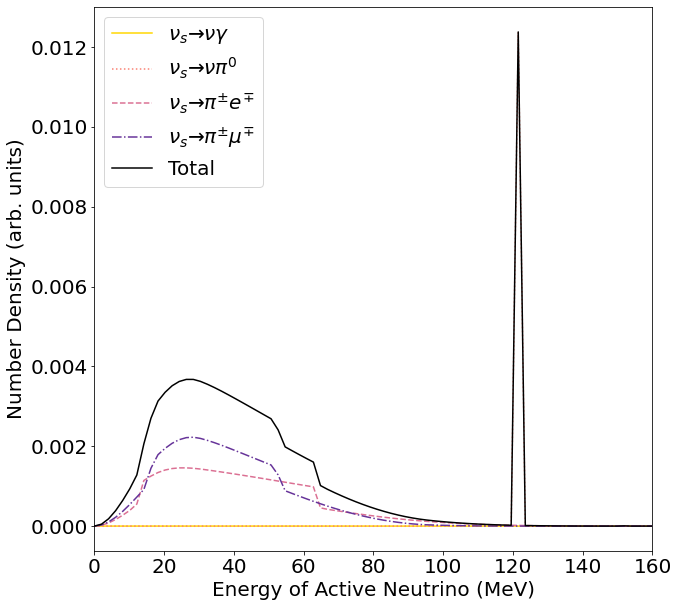

In [13]:
plt.figure(figsize=(10,10))

plt.plot(e_array,totalnum1,color = 'gold', label="$\\nu_s \\to \\nu\gamma$")
plt.plot(e_array,totalnum2,color = 'salmon', linestyle =":", label="$\\nu_s \\to \\nu\pi^0$")
plt.plot(e_array,totalnum3,color = 'palevioletred', linestyle ="--", label="$\\nu_s \\to \pi^{\pm}e^{\mp}$")
plt.plot(e_array,totalnum4,color = 'rebeccapurple', linestyle ="-.", label="$\\nu_s \\to \pi^{\pm}\mu^{\mp}$")
plt.plot(e_array,totalnumsum, color='black',label='Total')
plt.xlabel("Energy of Active Neutrino (MeV)",fontsize=20)
plt.ylabel("Number Density (arb. units)",fontsize=20)
plt.tick_params(axis='x', labelsize=20)
plt.tick_params(axis='y', labelsize=20)
plt.xlim(0,160)
plt.legend(loc="upper left",fontsize=20)
plt.savefig("NumberDensity.pdf")